# Learning Experiment

In [65]:
from draco.learn import linear
from draco.learn import data_util
from draco.run import run
from draco.spec import Task, Query, AspTask, Encoding, Field, Data
from draco.learn.helper import count_violations
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import logging
from vega3 import VegaLite

logging.basicConfig()
logging.getLogger().setLevel(logging.WARN)

In [66]:
data, _ = data_util.load_data(test_size=0)
data = data[data.source != 'manual']

raw_data = data_util.load_neg_pos_specs()

data_yh = data[data.source == 'younghoon'] 
data_bh = data[data.source == 'bahador']

X = data.negative - data.positive
X_yh = data_yh.negative - data_yh.positive
X_bh = data_bh.negative - data_bh.positive

In [67]:
len(data_yh), len(X_yh), len(X_bh), len(data_bh)

(880, 880, 10, 10)

In [68]:
X_yh_train, X_yh_test = train_test_split(X_yh, test_size=0.3)
X_bh_train, X_bh_test = train_test_split(X_bh, test_size=0.3)

In [69]:
clf = linear.train_model(pd.concat([X_yh_train, X_bh]), test_size=0.3)
print()
print(clf.score(X, np.ones(len(X))))
print(clf.score(X_yh_test, np.ones(len(X_yh_test))))
print(clf.score(X_bh, np.ones(len(X_bh))))

Train score:  0.9657534246575342
Dev score:  0.9414893617021277

0.9561797752808989
0.9507575757575758
0.9


In [70]:
clf = linear.train_model(X_bh, test_size=0)

clf.score(X_bh, np.ones(len(X_bh)))

Train score:  1.0


1.0

In [71]:
clf = linear.train_model(X_yh_train, test_size=0.3)

clf.score(X_yh_test, np.ones(len(X_yh_test)))

Train score:  0.9651972157772621
Dev score:  0.9567567567567568


0.9507575757575758

# Apply a learned model to partial specifications

See whether it comes up with the optimum

In [72]:
clf = linear.train_model(X, test_size=0)

Train score:  0.9606741573033708


In [73]:
weights = clf.coef_[0]
names = X.columns

const_dict = dict(zip(map(lambda x: f'{x}_weight', names), map(int, weights*1000)))

In [74]:
def to_name(spec):
    enc = spec['encoding']
    
    d = {}
    
    d[enc['x']['field']] = 'x'
    d[enc['y']['field']] = 'y'
    
    if 'color' in enc:
        color = enc['color']['field']
        d[color] = 'color'
    if 'size' in enc:
        size = enc['size']['field']
        d[size] = 'size'
    if 'row' in enc:
        row = enc['row']['field']
        d[row] = 'row'

    return f'Q1:{d["q1"]}, Q2:{d["q2"]}, N:{d["n"]}'

In [90]:
def get_encoding(cardinality, per_category, entropy_q1, entropy_q2, task):
    data_size = per_category * cardinality
    fields = list(map(Field.from_obj, [
        {
          "name": "n",
          "type": "string",
          "entropy": 1,
          "cardinality": cardinality,
          "interesting": task == 'summary'
        }, {
          "name": "q1",
          "type": "number",
          "entropy": entropy_q1,
          "cardinality": data_size,
          "interesting": True
        }, {
          "name": "q2",
          "type": "number",
          "entropy": entropy_q2,
          "cardinality": data_size
        }
    ]))
    spec_schema = Data(fields, data_size)
    spec_schema.fill_with_random_content()

    query_task = Task(spec_schema,
                Query(
                    mark=None,
                    encodings=[
                        Encoding(field='q1', ty='quantitative'),
                        Encoding(field='q2', ty='quantitative'),
                        Encoding(field='n', ty='nominal')
                    ]),
                task=task)

    return run(query_task,
        constants=const_dict,
        files=['define.lp', 'generate.lp', 'test.lp', 'features.lp', 'weights.lp',
               'assign_weights.lp', 'optimize.lp', 'output.lp', 'younghoon.lp'],
        clear_cache=True)

In [94]:
cardinalities = [3, 10, 20]
per_categories = [3, 30]
entropy = [3.9, 0.8]
tasks = ['value', 'summary']

In [100]:
for task in tasks:
    for cardinality in cardinalities:
        for per_category in per_categories:
            for entropy_q1 in entropy:
                for entropy_q2 in entropy:
                    out = get_encoding(cardinality, per_category, entropy_q1, entropy_q2, task)
                    print(task, ',', cardinality, ',', per_category, ',', entropy_q1, ',', entropy_q2, ',', to_name(out.to_vegalite()))

value , 3 , 3 , 3.9 , 3.9 , Q1:y, Q2:x, N:color
value , 3 , 3 , 3.9 , 0.8 , Q1:y, Q2:x, N:color


value , 3 , 3 , 0.8 , 3.9 , Q1:y, Q2:x, N:color
value , 3 , 3 , 0.8 , 0.8 , Q1:y, Q2:x, N:color


value , 3 , 30 , 3.9 , 3.9 , Q1:y, Q2:x, N:color


value , 3 , 30 , 3.9 , 0.8 , Q1:y, Q2:x, N:color
value , 3 , 30 , 0.8 , 3.9 , Q1:y, Q2:x, N:color


value , 3 , 30 , 0.8 , 0.8 , Q1:y, Q2:x, N:color
value , 10 , 3 , 3.9 , 3.9 , Q1:y, Q2:x, N:color


value , 10 , 3 , 3.9 , 0.8 , Q1:y, Q2:x, N:color
value , 10 , 3 , 0.8 , 3.9 , Q1:y, Q2:x, N:color


value , 10 , 3 , 0.8 , 0.8 , Q1:y, Q2:x, N:color
value , 10 , 30 , 3.9 , 3.9 , Q1:y, Q2:x, N:color


value , 10 , 30 , 3.9 , 0.8 , Q1:y, Q2:x, N:color
value , 10 , 30 , 0.8 , 3.9 , Q1:y, Q2:x, N:color


value , 10 , 30 , 0.8 , 0.8 , Q1:y, Q2:x, N:color
value , 20 , 3 , 3.9 , 3.9 , Q1:y, Q2:x, N:color


value , 20 , 3 , 3.9 , 0.8 , Q1:y, Q2:x, N:color
value , 20 , 3 , 0.8 , 3.9 , Q1:y, Q2:x, N:color


value , 20 , 3 , 0.8 , 0.8 , Q1:y, Q2:x, N:color


value , 20 , 30 , 3.9 , 3.9 , Q1:y, Q2:x, N:color


value , 20 , 30 , 3.9 , 0.8 , Q1:y, Q2:x, N:color


value , 20 , 30 , 0.8 , 3.9 , Q1:y, Q2:x, N:color


value , 20 , 30 , 0.8 , 0.8 , Q1:y, Q2:x, N:color
summary , 3 , 3 , 3.9 , 3.9 , Q1:y, Q2:color, N:x


summary , 3 , 3 , 3.9 , 0.8 , Q1:y, Q2:color, N:x
summary , 3 , 3 , 0.8 , 3.9 , Q1:y, Q2:color, N:x


summary , 3 , 3 , 0.8 , 0.8 , Q1:y, Q2:color, N:x
summary , 3 , 30 , 3.9 , 3.9 , Q1:y, Q2:color, N:x


summary , 3 , 30 , 3.9 , 0.8 , Q1:y, Q2:color, N:x
summary , 3 , 30 , 0.8 , 3.9 , Q1:y, Q2:color, N:x


summary , 3 , 30 , 0.8 , 0.8 , Q1:y, Q2:color, N:x
summary , 10 , 3 , 3.9 , 3.9 , Q1:y, Q2:color, N:x


summary , 10 , 3 , 3.9 , 0.8 , Q1:y, Q2:color, N:x
summary , 10 , 3 , 0.8 , 3.9 , Q1:y, Q2:color, N:x


summary , 10 , 3 , 0.8 , 0.8 , Q1:y, Q2:color, N:x
summary , 

10 , 30 , 3.9 , 3.9 , Q1:size, Q2:x, N:y


summary , 10 , 30 , 3.9 , 0.8 , Q1:size, Q2:x, N:y
summary , 10 , 30 , 0.8 , 3.9 , Q1:y, Q2:color, N:x


summary , 10 , 30 , 0.8 , 0.8 , Q1:size, Q2:x, N:y
summary , 20 , 3 , 3.9 , 3.9 , Q1:y, Q2:color, N:x
summary , 20 , 3 , 3.9 , 0.8 , Q1:y, Q2:color, N:x


summary , 20 , 3 , 0.8 , 3.9 , Q1:y, Q2:color, N:x
summary , 20 , 3 , 0.8 , 0.8 , Q1:y, Q2:color, N:x


summary , 20 , 30 , 3.9 , 3.9 , Q1:size, Q2:x, N:y


summary , 20 , 30 , 3.9 , 0.8 , Q1:size, Q2:x, N:y
summary , 20 , 30 , 0.8 , 3.9 , Q1:y, Q2:color, N:x


summary , 20 , 30 , 0.8 , 0.8 , Q1:size, Q2:x, N:y


Cost: -609
Q1:size, Q2:x, N:y


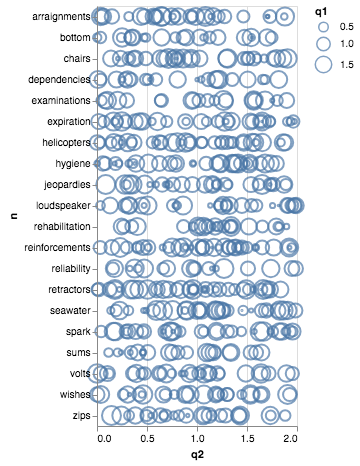

In [91]:


#                      0            1            2            3            4            5
configurations = [(0,0,0,0,0), (1,0,0,0,0), (2,0,0,0,0), (0,1,0,0,0), (0,0,1,0,0), (0,0,0,1,0),
                  (0,0,0,0,1), (1,0,0,0,1), (2,0,0,0,1), (0,1,0,0,1), (0,0,1,0,1), (0,0,0,1,1)]
#                       6           7            8            9           10           11

cardinality = cardinalities[2]  # 0,1,2
per_category = per_categories[1]  # 0,1
entropy_q1 = entropy[0]  # 0,1
entropy_q2 = entropy[1]  # 0,1
task = tasks[1]  # 0,1

# config = configurations[11]

out = get_encoding(cardinality, per_category, entropy_q1, entropy_q2, task)

print('Cost:', out.cost)
spec = out.to_vegalite()
print(to_name(spec))
VegaLite(spec)

Cost: 900


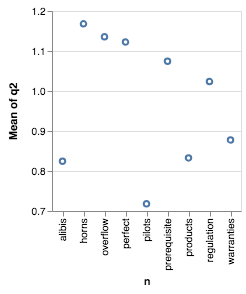

In [64]:
task = 'value'
mark = 'point'

fields = list(map(Field.from_obj, [
    {
      "name": "n",
      "type": "string",
      "cardinality": 9
    },
    {
      "name": "o1",
      "type": "number",
      "cardinality": 25
    },
    {
      "name": "q2",
      "type": "number",
      "cardinality": 407
    }
]))
spec_schema = Data(fields, data_size)
spec_schema.fill_with_random_content()

query_task = Task(spec_schema,
            Query(
                mark=mark,
                encodings=[
                    Encoding(channel='x', field='n', ty='nominal'),
                    # Encoding(channel='x', field='o1', ty='ordinal'),
                    Encoding(channel='y', field='q2', ty='quantitative'),
                ]),
            task=task
           )

out = run(query_task,
    constants=const_dict,
    files=['define.lp', 'generate.lp', 'test.lp', 'features.lp', 'weights.lp',
           'assign_weights.lp', 'optimize.lp', 'output.lp', 'bahador.lp'],
    clear_cache=True
   )

print('Cost:', out.cost)

spec = out.to_vegalite()
VegaLite(spec)